# Grid Study and Sensitivity Analysis

In [5]:
#import kelp_param
import kelp3d_objs as k3
import ipyparallel as ipp
import concurrent.futures as cf
import itertools as it
from sympy import divisors
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt
from scipy.interpolate import interp1d
import ipcluster_magics

ModuleNotFoundError: No module named 'fortran_wrappers.pykelp3d_wrap'

In [45]:
%ipcluster start -N 1 -t 4:00:00 -e kelp -d /global/homes/o/oevans/kelp/code/python

salloc: Pending job allocation 13085240
salloc: job 13085240 queued and waiting for resources
salloc: job 13085240 has been allocated resources
salloc: Granted job allocation 13085240
salloc: Waiting for resource configuration
salloc: Nodes nid00014 are ready for job
2018-06-07 07:25:37.962 [scheduler] Scheduler started [leastload]


In [24]:
# %ipcluster stop

Stopped job 13083152.
salloc: Job allocation 13083152 has been revoked.
slurmstepd: error: *** STEP 13083152.0 ON nid00016 CANCELLED AT 2018-06-07T03:58:47 ***
Connection to nid00016 closed by remote host.
srun: Job step aborted: Waiting up to 32 seconds for job step to finish.
srun: error: nid00019: task 3: Terminated
srun: Terminating job step 13083152.0
srun: error: nid00018: task 2: Terminated
srun: error: nid00017: task 1: Terminated
srun: error: nid00016: task 0: Terminated


In [46]:
remote_config = kelp_param.ParamSpanRemoteConfig()
ipc = ipp.Client()
lv = ipc.load_balanced_view()
dv = ipc.direct_view()
print(ipc.ids)

[0]


def cdkelp():
    import os
    os.chdir('/global/homes/o/oevans/kelp/code/python')
dv.apply(cdkelp)

In [47]:
def exp_fun(x, c, a):
    return c*np.exp(-a*x)

### Define Constants

In [48]:
# Hard-coded parameters
rope_spacing = 5.0 # (m)
zmin, zmax = 0.0, 10.0 # (m)

# Light from above
I0 = 50.0 # (W/m^2)
phi_s = 0 # (rad)
theta_s = 0 # (rad)
decay = 0 # (?) - light (practically) only from directly above

# Calculated or otherwise boring parameters
xmin = -rope_spacing/2
xmax = rope_spacing/2
ymin = -rope_spacing/2
ymax = rope_spacing/2

# Solver parameters
lis_options = "-i gmres -restart 10000 -tol 1e-4"

const = (rope_spacing, zmin, zmax, I0, phi_s, theta_s, decay, xmin, xmax, ymin, ymax,
         lis_options)

# Compare FD & Exact Solution

In [6]:
# Set parameters
a_water = 0.5
b = 0.00
ns = 10
na = 10
kelp_profile='none'

nz_max = 24
nz_list = np.array(divisors(24))
nz_list = nz_list[nz_list>3]

# Exact solution (no kelp, no scattering)
exact_results = lv.apply(kelp_param.kelp_calculate,
    a_water,
    b,
    ns,
    na,
    nz_max,
    kelp_profile,
    absorptance_kelp=0.8,
    gmres_flag=False,
    num_scatters=0,
    const=const
).result()

exact_irrad = exact_results['irradiance'].mean(axis=(0,1))

irrad_list = []
abs_err_list = []
rel_err_list = []

# Run scattering cases
for nz in nz_list:
    print("nz={}".format(nz))
    #print("const={}".format(const))
    compute_results = lv.apply(kelp_param.kelp_calculate,
        a_water,
        b,
        ns,
        na,
        nz,
        kelp_profile,
        absorptance_kelp=0.8,
        gmres_flag=True,
        num_scatters=0,
        const=const
    ).result()

    irrad = compute_results['irradiance'].mean(axis=(0,1))
    irrad_list.append(irrad)
    
    block_exact_irrad = kelp_param.block_mean(exact_irrad, irrad.shape)
    abs_err = np.mean(np.abs(irrad-block_exact_irrad))
    abs_err_list.append(abs_err)
    rel_err = np.mean(np.abs(irrad-block_exact_irrad)/block_exact_irrad)
    rel_err_list.append(rel_err)

 Grid
 IOPs
 max abs =  0.500000000000000     
 max loc =           1           1           1
 BC
 Scatter
nz=4
 Irrad
 deinit
 done
 Grid
 IOPs
 max abs =  0.500000000000000     
 max loc =           1           1           1
 BC
 Scatter
 Sparse Matrix
 num_procs =          64
 ntz =           4
 ntx =          10
 nty =           1
 k =           1
 k =           2
 k =           3
 k =           4
 Setting solver opts: '-i gmres -restart 10000 -tol 1e-12'
 Light
 Calculate Radiance
nz=6
 Irrad
 deinit
 done
 Grid
 IOPs
 max abs =  0.500000000000000     
 max loc =           1           1           1
 BC
 Scatter
 Sparse Matrix
 num_procs =          64
 ntz =           6
 ntx =          10
 nty =           1
 k =           1
 k =           2
 k =           4
 k =           3
 k =           5
 k =           6
 Setting solver opts: '-i gmres -restart 10000 -tol 1e-12'
 Light
 Calculate Radiance
nz=8
 Irrad
 deinit
 done
 Grid
 IOPs
 max abs =  0.500000000000000     
 max loc =        

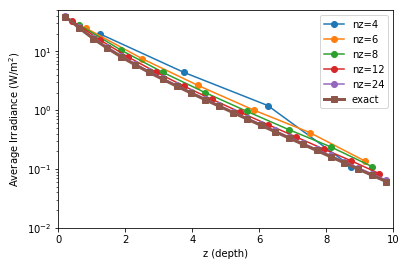

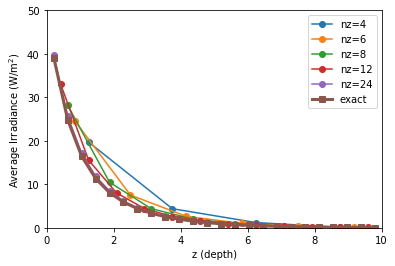

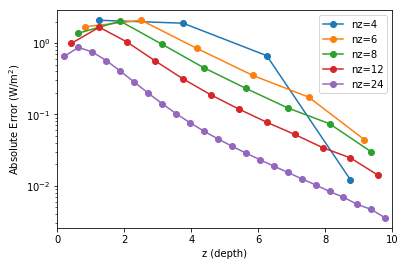

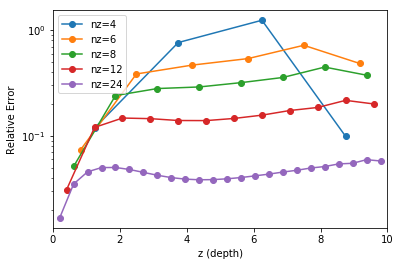

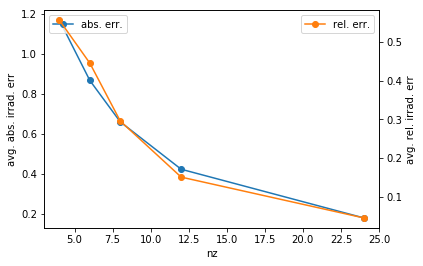

In [7]:
plt.figure()
for nz, irrad in zip(nz_list, irrad_list):
    dz = (zmax-zmin)/nz
    z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)
    plt.plot(z, irrad, '-o', label='nz={}'.format(nz))
dz = (zmax-zmin)/max(nz_list)
z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz_max)
plt.plot(z, exact_irrad, '-s', lw=3, label='exact')
plt.yscale('log')
plt.xlim(zmin, zmax)
plt.ylim(1e-2, I0)
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel(r'Average Irradiance ($\mathrm{W/m}^2$)')
plt.savefig('exact_vs_fd_log_irrad.png', dpi=300)

plt.figure()
for nz, irrad in zip(nz_list, irrad_list):
    dz = (zmax-zmin)/nz
    z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)
    plt.plot(z, irrad, '-o', label='nz={}'.format(nz))
dz = (zmax-zmin)/nz_max
z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz_max)
plt.plot(z, exact_irrad, '-s', lw=3, label='exact')
plt.yscale('linear')
plt.xlim(zmin, zmax)
plt.ylim(0, I0)
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel(r'Average Irradiance ($\mathrm{W/m}^2$)')
plt.savefig('exact_vs_fd_irrad.png', dpi=300)

plt.figure()
for nz, irrad in zip(nz_list, irrad_list):
    dz = (zmax-zmin)/nz
    z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)
    block_exact_irrad = kelp_param.block_mean(exact_irrad, [nz])
    plt.plot(z, np.abs(irrad-block_exact_irrad), '-o', label='nz={}'.format(nz))
plt.yscale('log')
plt.xlim(zmin, zmax)
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel(r'Absolute Error ($\mathrm{W/m}^2$)')
plt.savefig('exact_vs_fd_abs_err.png', dpi=300)

plt.figure()
for nz, irrad in zip(nz_list, irrad_list):
    dz = (zmax-zmin)/nz
    z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)
    block_exact_irrad = kelp_param.block_mean(exact_irrad, [nz])
    plt.plot(z, np.abs((irrad-block_exact_irrad)/block_exact_irrad), '-o', label='nz={}'.format(nz))
plt.yscale('log')
plt.xlim(zmin, zmax)
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel('Relative Error')
plt.savefig('exact_vs_fd_rel_err.png', dpi=300)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(nz_list, abs_err_list, 'C0o-', label='abs. err.')
ax1.set_xlabel('nz')
ax1.set_ylabel('avg. abs. irrad. err')
ax1.legend(loc='upper left')
ax2.plot(nz_list, rel_err_list, 'C1o-', label='rel. err.')
ax2.set_ylabel('avg. rel. irrad. err')
ax2.legend(loc='upper right')
plt.savefig('exact_vs_fd_compare.png', dpi=300)

plt.show()

# Grid Study

# Grid Study 1

In [3]:
ipp.Client()

NameError: name 'ipp' is not defined

In [49]:
# Set parameters
a_water = 0.179
b = 0.219
absorptance_kelp = 0.8
kelp_profile='top-heavy'
ns_max = 8
nz_max = 8
na_max = 8
ns_list = range(4, ns_max+1, 4)
nz_list = range(4, nz_max+1, 4)
na_list = range(4, na_max+1, 4)

ex = cf.ThreadPoolExecutor()
gs_fut = ex.submit(
    grid_study_compute,
    a_water, absorptance_kelp, kelp_profile, ns_list, nz_list, na_list
)

ns_max = 24
nz_max = 24
na_max = 20


In [ ]:
perceived_irrad_dict, abs_err_arr, rel_err_arr, duration = gs_fut.result()

 Grid
 IOPs
 max abs =   3.19474980160132     
 max loc =          17          16           3
 BC
 Scatter
 scatter #           1
 source:  -0.106205838023444       -4.78462607267705     
   3.56706091008630     
 scatter #           2
 source:   0.336293337299717       -9.67294297056050     
   12.8943556236126     
 scatter #           3
 source:  -0.992587589222426       -50.0295299141890     
   29.9822733243622     
 scatter #           4
 source:    2.65303081478060       -81.9513013141404     
   185.857214584268     
 Sparse Matrix
 num_procs =          64
 ntz =          24
 ntx =           2
 nty =           1
 k =           1
 k =           2
 k =           4
 k =           9
 k =          14
 k =          13
 k =          17
 k =          21
 k =          23
 k =           8
 k =           5
 k =          22
 k =           7
 k =          20
 k =          10
 k =          18
 k =          12
 k =          16
 k =          19
 k =          11
 k =          15
 k =           

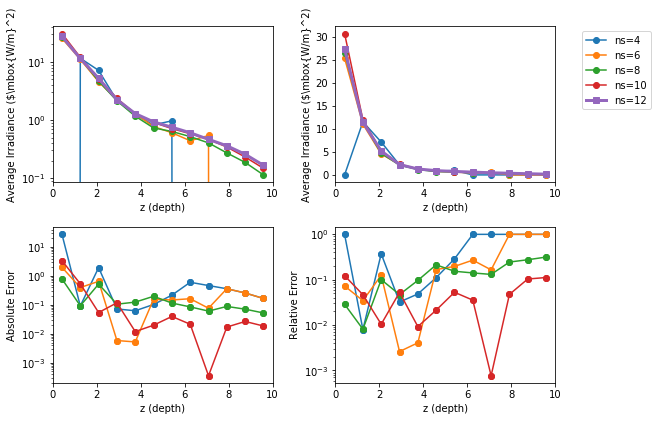

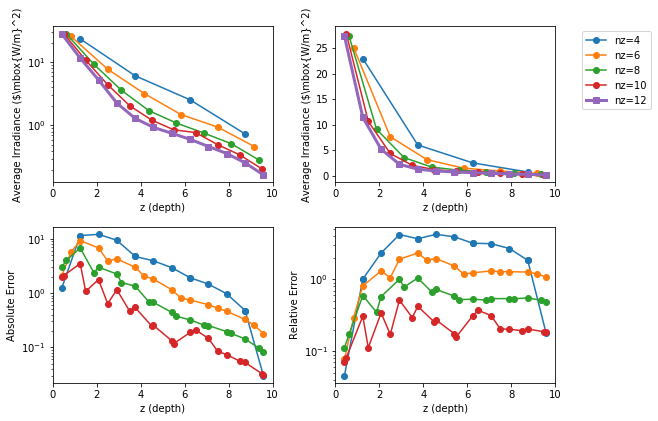

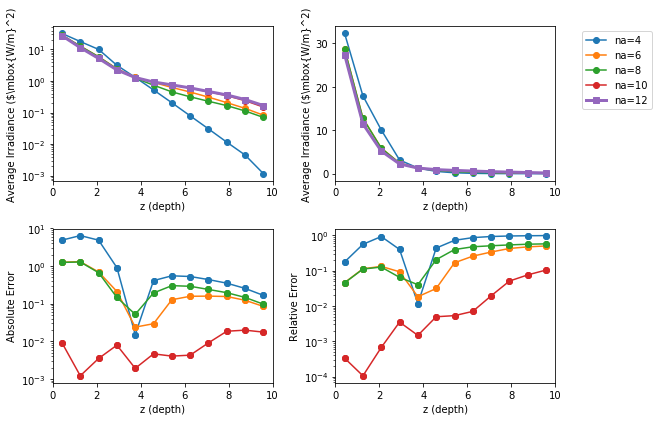

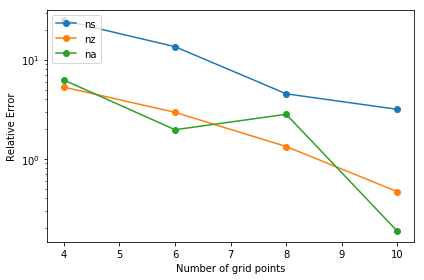

In [39]:
grid_study_plot(ns_list, nz_list, na_list, perceived_irrad_dict, abs_err_arr, rel_err_arr)

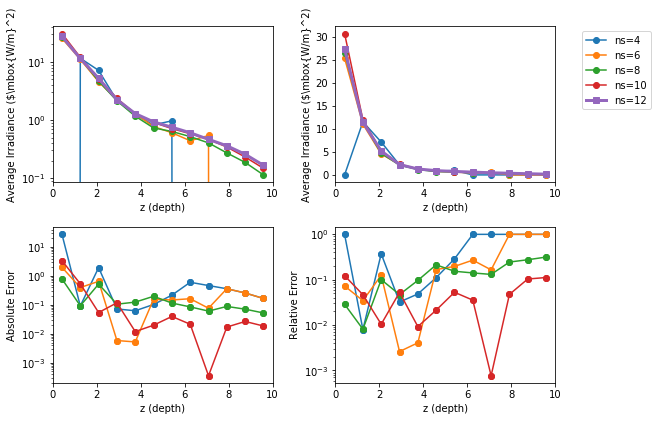

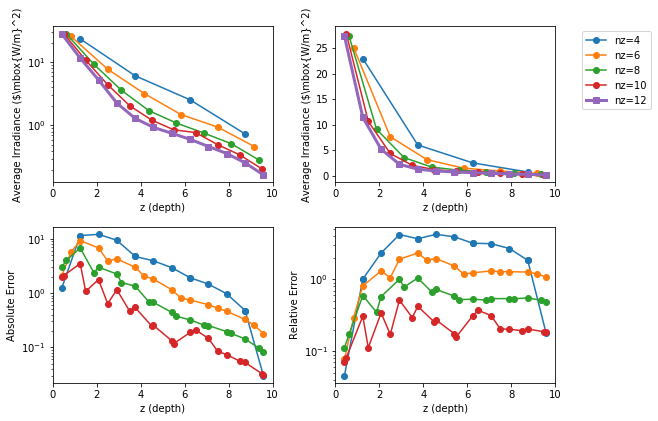

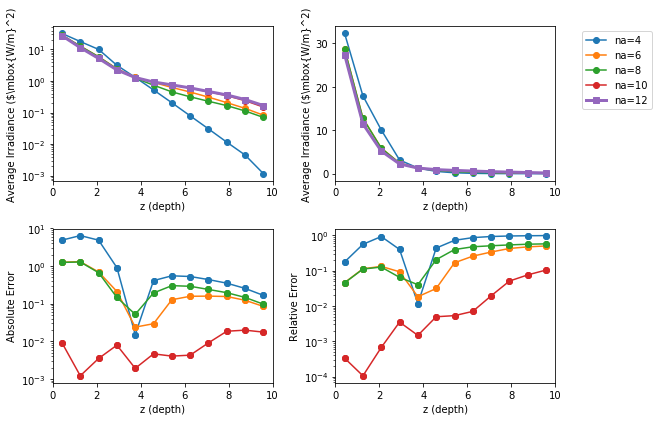

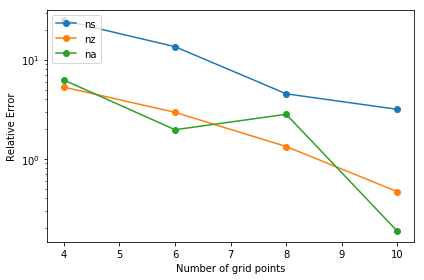

In [40]:
grid_study_plot(ns_list, nz_list, na_list, perceived_irrad_dict, abs_err_arr, rel_err_arr)

# Grid Study 2

In [44]:
# Set parameters
a_water = 0.5
b = 0.05
absorptance_kelp = 0.8
kelp_profile='top-heavy'
ns_max = 16
nz_max = 16
na_max = 2
na_list = range(4,na_max+1,4)

irrad_dict, abs_err_arr, rel_err_arr = grid_study_compute(a_water, absorptance_kelp, kelp_profile, [ns_max], [nz_max], na_list)

ns_max = 16
nz_max = 16
na_max = 36
 Grid
 IOPs
 max abs =   2.50243483408791     
 max loc =           9          11           4
 BC
 Scatter
 scatter #           1
 source:  -6.976258431004068E-002  -4.57632965327734     
   2.51396029278386     
 scatter #           2
 source:   0.110409603921986       -3.90831692391651     
   3.84173837083163     
 scatter #           3
 source:  -0.183114400573926       -5.48414676678398     
   7.17832530232531     
 scatter #           4
 source:   0.298833187029190       -12.9023018619256     
   8.94732320519005     
 Sparse Matrix
 num_procs =          64
 ntz =          16
 ntx =           4
 nty =           1
 k =           2
 k =           1
 k =          11
 k =          12
 k =           6
 k =          13
 k =          16
 k =           5
 k =           7
 k =           9
 k =          15
 k =          14
 k =          10
 k =           4
 k =           3
 k =           8
 Setting solver opts: '-i gmres -restart 10000 -tol 1e-12'
 Ligh

KeyboardInterrupt: 

In [20]:
c = ipp.Client()

In [21]:
c.queue_status()

{'unassigned': 0,
 0: {'queue': 0, 'completed': 4, 'tasks': 0},
 1: {'queue': 0, 'completed': 4, 'tasks': 0},
 2: {'queue': 0, 'completed': 4, 'tasks': 0},
 3: {'queue': 0, 'completed': 4, 'tasks': 0}}

In [22]:
# Set parameters
a_water = 0.5
b = 0.05
absorptance_kelp = 0.8
kelp_profile='top-heavy'
ns_max = 20
nz_max = 20
na_max = 20
ns_list = range(4, ns_max+1, 2)
nz_list = range(4, nz_max+1, 2)
na_list = range(4, na_max+1, 2)

ex = cf.ThreadPoolExecutor()
gs2_fut = ex.submit(
    grid_study_compute,
    a_water, absorptance_kelp, kelp_profile, ns_list, nz_list, na_list
)

ns_max = 20
nz_max = 20
na_max = 20
 Grid
 IOPs
 max abs =   3.00304420412469     
 max loc =          11          11           3
 BC
 Scatter
 scatter #           1
 source:  -5.425971275757289E-002  -4.60755706707517     
   2.81610628536718     
 scatter #           2
 source:   8.405146682828540E-002  -3.27873063768493     
   3.92538485136958     
 scatter #           3
 source:  -0.138017032916213       -5.51155646626849     
   5.52823584716663     
 scatter #           4
 source:   0.224859148316283       -9.62615963766267     
   9.06730275457610     
 Sparse Matrix
 num_procs =          64
 ntz =          20
 ntx =           3
 nty =           1
 k =           1
 k =           2
 k =          17
 k =          12
 k =          13
 k =           3
 k =           9
 k =           4
 k =           8
 k =          10
 k =          20
 k =           5
 k =          11
 k =          16
 k =          18
 k =          14
 k =          15
 k =           6
 k =           7
 k =         

In [23]:
perceived_irrad_dict, abs_err_arr, rel_err_arr = gs2_fut.result()

.798811E-09
iteration:   157  relative residual = 4.284253E-09
iteration:   158  relative residual = 3.817079E-09
iteration:   159  relative residual = 3.409581E-09
iteration:   160  relative residual = 3.042182E-09
iteration:   161  relative residual = 2.721947E-09
iteration:   162  relative residual = 2.432844E-09
iteration:   163  relative residual = 2.177490E-09
iteration:   164  relative residual = 1.947959E-09
iteration:   165  relative residual = 1.743942E-09
iteration:   166  relative residual = 1.562334E-09
iteration:   167  relative residual = 1.402541E-09
iteration:   168  relative residual = 1.259768E-09
iteration:   169  relative residual = 1.130851E-09
iteration:   170  relative residual = 1.015437E-09
iteration:   171  relative residual = 9.111838E-10
iteration:   172  relative residual = 8.167058E-10
iteration:   173  relative residual = 7.327544E-10
iteration:   174  relative residual = 6.568978E-10
iteration:   175  relative residual = 5.895386E-10
iteration:   176  r

/global/homes/o/oevans/local/miniconda3/envs/kelp/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in true_divide


ValueError: too many values to unpack (expected 2)

iterati Irrad
 deinit
 done


In [ ]:
grid_study_plot(ns_list, nz_list, na_list, perceived_irrad_dict, abs_err_arr, rel_err_arr)

# Asymptotics Accuracy

In [ ]:
# Set parameters
aut8 = [0.144, 0.037]
hao11 = [0.179, 0.219]
nuc2200 = [0.337, 1.583]
nuc2240 = [0.125, 1.205]
petzold_iops = [aut8, hao11, nuc2200, nuc2240]
petzold_names = ['aut8', 'hao11', 'nuc2200', 'nuc2240']

ns = 22
na = 22
nz = 22
kelp_profile='top-heavy'
max_scatter = 16

asym_conv_true_pi = {}
asym_conv_gmres_time = {}

for name, (a_water, b) in zip(petzold_names, petzold_iops):
    # GMRES
    gmres_results = lv.apply(kelp_param.kelp_calculate,
        a_water,
        b,
        ns,
        na,
        nz,
        kelp_profile,
        absorptance_kelp=0.8,
        gmres_flag=True,
        num_scatters=0,
        const=const
    ).result()

    p_kelp = gmres_results['p_kelp']
    true_irrad = gmres_results['irradiance']
    true_rad = gmres_results['radiance']
    asym_conv_gmres_time[name] = gmres_results['duration']
    true_perceived_irrad = np.sum(p_kelp*true_irrad, axis=(0,1)) / np.sum(p_kelp, axis=(0,1))
    asym_conv_true_pi[name] = true_perceived_irrad

In [ ]:
save_dict = {}
res_dict = {}

scat_nums = range(0, max_scatter+1, 4)
# Run scattering cases
for name, (a_water, b) in zip(petzold_names, petzold_iops):
    res_list = []
    save_list = []
    true_perceived_irrad = asym_conv_true_pi[name]
    for n in scat_nums:
        print("n={}".format(n))
        #print("const={}".format(const))
        compute_results = lv.apply(kelp_param.kelp_calculate,
            a_water,
            b,
            ns,
            na,
            nz,
            kelp_profile,
            absorptance_kelp=0.8,
            gmres_flag=False,
            num_scatters=n,
            const=const
        ).result()

        irrad = compute_results['p_kelp']
        irrad = compute_results['irradiance']
        # Perceived irradiance for each depth layer
        perceived_irrad = np.sum(p_kelp*irrad, axis=(0,1)) / np.sum(p_kelp, axis=(0,1))
        perc_abs_err = np.abs(true_perceived_irrad - perceived_irrad)
        perc_rel_err = np.abs((true_perceived_irrad - perceived_irrad)/true_perceived_irrad)

        save_vals = {
            'irrad': irrad.mean(axis=(0,1)),
            'perceived_irrad': perceived_irrad,
            'perc_abs_err': perc_abs_err,
            'perc_rel_err': perc_rel_err,
            'duration': compute_results['duration']
        }

        res_list.append(compute_results)
        save_list.append(save_vals)
    res_dict[name] = res_list
    save_dict[name] = save_list

In [ ]:
import dill

### Plot Convergence Curves

In [ ]:
!mkdir data figures -p

In [ ]:
with open("data/asym_conv_save.dill", 'wb') as fh:
    dill.dump(save_dict, fh)

In [ ]:
with open("data/asym_conv_res.dill", 'wb') as fh:
    dill.dump(res_dict, fh)

In [ ]:
with open("data/asym_conv_gmres.dill", 'wb') as fh:
    dill.dump(gmres_results, fh)

In [ ]:
dz = (zmax-zmin)/nz
z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)
for name, iops in zip(petzold_names, petzold_iops):
    true_perceived_irrad = asym_conv_true_pi[name]
    plt.figure(figsize=[8,6])
    for i, scat in enumerate(res_dict[name]):
        plt.plot(z, save_dict[name][i]['perceived_irrad'], 'o-', label='n={}'.format(scat_nums[i]))
    
    plt.plot(z, np.abs(true_perceived_irrad), 's-', lw=3, label='FD')
    plt.title("{}: a_water={}, b={}".format(name, *iops))
    plt.xlabel('z (m)')
    plt.ylabel(r'Perceived Irradiance ($\mathrm{W/m}^2$)')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.savefig('figures/asym_conv_irrad_{}.png'.format(name), dpi=300)
    
plt.show()

In [ ]:
dz = (zmax-zmin)/nz
z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)
for name, iops in zip(petzold_names, petzold_iops):
    true_perceived_irrad = asym_conv_true_pi[name]
    plt.figure(figsize=[8,6])
    for i, scat in enumerate(res_dict[name]):
        plt.plot(z, save_dict[name][i]['perc_rel_err'], 'o-', label='n={}'.format(scat_nums[i]))
    
    #plt.plot(z, np.abs(true_perceived_irrad), 'o-', label='FD')
    plt.title("{}: a_water={}, b={}".format(name, *iops))
    plt.xlabel('z (m)')
    plt.ylabel('Relative Error: Perceived Irradiance')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.savefig('figures/asym_conv_rel_err_{}.png'.format(name), dpi=300)
    
plt.show()

In [ ]:
plt.figure(figsize=[8,6])
for name, iops in zip(petzold_names[:-2], petzold_iops[:-2]):
    abs_err = np.array([res['perc_abs_err'].mean() for res in save_dict[name]])
    rel_err = np.array([res['perc_rel_err'].mean() for res in save_dict[name]])
    plt.plot(scat_nums, rel_err, 'o-', label='{}: a={}, b={}'.format(name, *iops))
    
plt.xticks(scat_nums)
plt.xlabel('# of Scattering Events')
plt.ylabel('Relative Error (Perceived Irrad)')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('figures/asym_conv_compare.png')
plt.show()

In [ ]:
np.array([res['perc_rel_err'].mean() for res in save_dict['aut8']])

# Sensitivity Analysis

In [ ]:
def f(x, y):
    print("x={}, y={}")

In [ ]:
def vary_params(**user_params):
    """Supply lists of param values. Only specify ones you're interested in. 
    Will be varied from base case separately."""
    base_params = {
        'a_water': 0.179,
        'b': 0.219,
        'ns': 16,
        'na': 16,
        'nz': 16,
        'absorptance_kelp': 0.8,
        'kelp_profile': 'top-heavy',
        'gmres_flag': False,
        'num_scatters': 12,
        'const': const
    }
    
    results_dict = {}
    perceived_irrad_dict = {}
    
    # Combine, with user overrides, one at a time.
    for param, vals in user_params.items():
        for val in vals:
            new_params = {**base_params, **{param: val}}
            compute_results = lv.apply(kelp_param.kelp_calculate, **new_params).result()
            results_dict[(param, val)] = compute_results
    
            p_kelp = compute_results['p_kelp']
            irrad = compute_results['irradiance']
            perceived_irrad = np.sum(p_kelp*irrad, axis=(0,1)) / np.sum(p_kelp, axis=(0,1))
            perceived_irrad_dict[(param, val)] = perceived_irrad
            
    
    return results_dict, perceived_irrad_dict

In [ ]:
def plot_params(user_dict, perceived_irrad_dict):
    for param, vals in user_dict.items():
        plt.figure()
        for val in vals:
            perceived_irrad = perceived_irrad_dict[(param, val)]
            nz = len(perceived_irrad)
            dz = (zmax-zmin)/nz
            z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)
            param_str = val
            if param == 'b':
                param_str = 'b/a={:.2f}'.format(val/a_water)
            elif isinstance(val, float):
                param_str = '{:.2f}'.format(val)
            plt.plot(z, perceived_irrad, 'o-', label='{}'.format(param_str))
        #plt.legend(loc='upper left', bbox_to_anchor=(1.05,1))
        plt.legend()
        plt.xlabel('z (m)')
        plt.ylabel(r'Perceived Irradiance ($\mathrm{W/m}^2$)')
        plt.yscale('log')
        plt.savefig('figures/sens_analysis_{}.png'.format(param), dpi=300)
        plt.tight_layout()
        plt.show()

In [ ]:
user_dict = dict(
    kelp_profile=['top-heavy', 'uniform', 'bottom-heavy'],
    absorptance_kelp=np.linspace(0.6,1.0,5),
    b = a_water * np.linspace(0.5, 2.0, 5)
)
results_dict, perceived_irrad_dict = vary_params(**user_dict)

In [ ]:
plot_params(user_dict, perceived_irrad_dict)

In [ ]:
user_dict = dict(
    b = a_water * np.linspace(0.5, 2.0, 10)
)
results_dict, perceived_irrad_dict = vary_params(**user_dict)

In [ ]:
plot_params(user_dict, perceived_irrad_dict)

In [ ]:
user_dict = dict(
    a_water = np.linspace(0.05, 0.5, 10)
)
results_dict, perceived_irrad_dict = vary_params(**user_dict)

In [ ]:
plot_params(user_dict, perceived_irrad_dict)